# This is a notebook for Solving PDEs as Petri Nets with PyCIEMSS

### Load dependencies

In [1]:
import os
import pyciemss
import pandas as pd
import requests
import json

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

smoke_test = ('CI' in os.environ)

### Set simulation parameters

In [2]:
start_time = 0.0
end_time = 100.0
logging_step_size = 10.0
num_timepoints = int((end_time - start_time - 1) // logging_step_size)
num_samples = 3 if smoke_test else 30

### Load models from [DARPA-ASKEM/Model-Representations](https://github.com/DARPA-ASKEM/Model-Representations/tree/pde-petri-amrs/petrinet/examples/pde/advection)

In [14]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/pde-petri-amrs/petrinet/examples/pde/advection/"
# MODEL_PATH = "../../docs/source/"

# Derivative type, dimension, boundary slope, and number of discrete points
PDE = ["advection", "halfar"] 
derivative_type = ["forward", "backward", "centered"] # Only backward derivative is working currently
dimension = [1, 2, 3] # Can't plot higher than 1D currently
boundary_slope = [0.0, 0.01, 0.1, 0.2]
num_discrete_points = [3, 5, 10]

def form_model_url(PDE: str, derivative_type: str, dimension: int, boundary_slope: float, num_discrete_points: int):
    
    model_string = PDE + "_" + derivative_type + "_" + str(dimension) + "_" 
    model_string = model_string + str(boundary_slope) + "_" + str(num_discrete_points) + ".json"
    model_url = os.path.join(MODEL_PATH, model_string)
    print("Model name:", model_string)
    
    return model_url

### Function to extract model states and x-coordinates

In [4]:
def extract_model_states_and_mesh(model_url):

    response = requests.get(model_url)
    model_dict = response.json()

    state_data = model_dict['model']['states']

    # Extracting states and x-coordinates from model
    state_names = [item['id'] for item in state_data]
    state_names = [state + '_state' for state in state_names]
    x_coords = [float(item['description'].split('[', 1)[1].split(']', 1)[0]) for item in state_data]

    print("State names:", state_names)
    print("X-coordinates:", x_coords)
    x_state_dict = {x: state for x, state in zip(x_coords, state_names)}
    
    return x_state_dict

### Function to reconfigure results for plotting

In [5]:
def reconfigure_results(result, x_state_dict, num_timepoints):
# For each timepoint, extract the corresponding solution across all states in the domain
    x_values = []
    all_y_values = []
    sid = []
    for i in range(num_timepoints):
        y_values = []
        df = result["data"][result["data"]["timepoint_id"] == i]
        # Extract states corresponding to each timepoint
        for sample_id in df['sample_id']:
            for x, column in x_state_dict.items():
                y_values.append(df.loc[df['sample_id'] == sample_id, column].values[0])
                x_values.append(x)
                sid.append(sample_id)
        all_y_values.append(y_values)

    # Move these into a DataFrame where labels are what is expected by plot
    timepoint_id = x_values[0:len(all_y_values[0])]
    sample_id = sid[0:len(all_y_values[0])]
    for i, sublist in enumerate(all_y_values, start=0):
        globals()[f"t{i}_state"] = sublist

    data = {
        'timepoint_id': timepoint_id,
        'sample_id': sample_id
    }
    for i, sublist in enumerate(all_y_values, start=0):
        data[f"t{i}_state"] = sublist

    return pd.DataFrame(data)

# 1-D Advection Equation
$$\frac{\partial a}{\partial t} = -u\frac{\partial a}{\partial x}$$ 

### Sample model and plot the results
1D Advection equation (backward derivative, boundary slope 0.1, 3 discrete points)

Model name: advection_backward_1_0.01_3.json
State names: ['a_0_state', 'a_1_state', 'a_2_state']
X-coordinates: [-1.5, 0.0, 1.5]


,timepoint_id,sample_id,persistent_dx_param,persistent_u_param,a_0_state,a_1_state,a_2_state
0,0,0,0.987428,0.559652,-0.144032,-0.103712,-0.043148
1,1,0,0.987428,0.559652,-0.321738,-0.290552,-0.259070
2,2,0,0.987428,0.559652,-0.498179,-0.467049,-0.435916
3,3,0,0.987428,0.559652,-0.674614,-0.643485,-0.612355
4,4,0,0.987428,0.559652,-0.851051,-0.819921,-0.788791


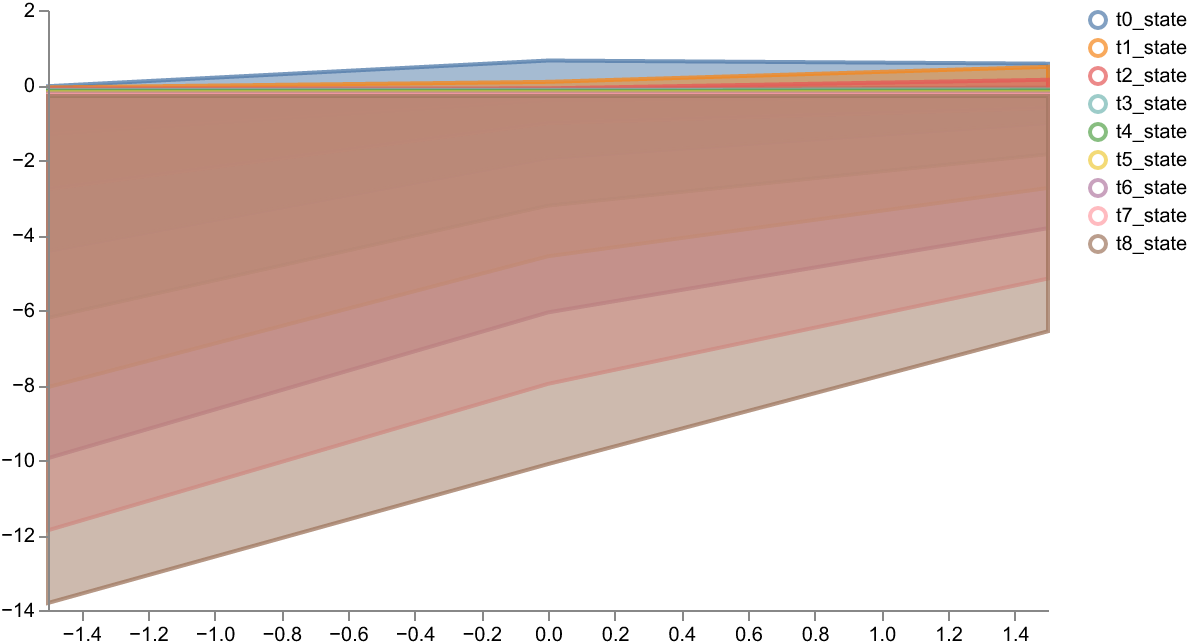

In [38]:
# 1D Advection equation (backward derivative, boundary slope 0.1, 3 discrete points)
model_url = form_model_url(PDE[0], derivative_type[1], dimension[0], boundary_slope[1], num_discrete_points[0])
x_state_dict = extract_model_states_and_mesh(model_url)

result = pyciemss.sample(model_url, end_time, logging_step_size, num_samples, start_time=start_time)
display(result["data"].head())

# Plot results for all states
reconfigured_results = reconfigure_results(result, x_state_dict, num_timepoints)
schema = plots.trajectories(reconfigured_results, keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Sample model and plot the results
1D Advection equation (backward derivative, boundary slope 0.1, 5 discrete points)

Model name: advection_backward_1_0.1_5.json
State names: ['a_0_state', 'a_1_state', 'a_2_state', 'a_3_state', 'a_4_state']
X-coordinates: [-2.0, -1.0, 0.0, 1.0, 2.0]


,timepoint_id,sample_id,persistent_dx_param,persistent_u_param,a_0_state,a_1_state,a_2_state,a_3_state,a_4_state
0,0,0,0.326484,0.765908,-0.408100,-0.389929,-0.371759,-0.353588,-0.335417
1,1,0,0.326484,0.765908,-0.834369,-0.816199,-0.798029,-0.779858,-0.761687
2,2,0,0.326484,0.765908,-1.260637,-1.242470,-1.224301,-1.206129,-1.187960
3,3,0,0.326484,0.765908,-1.686911,-1.668740,-1.650570,-1.632399,-1.614228
4,4,0,0.326484,0.765908,-2.113182,-2.095011,-2.076840,-2.058669,-2.040499


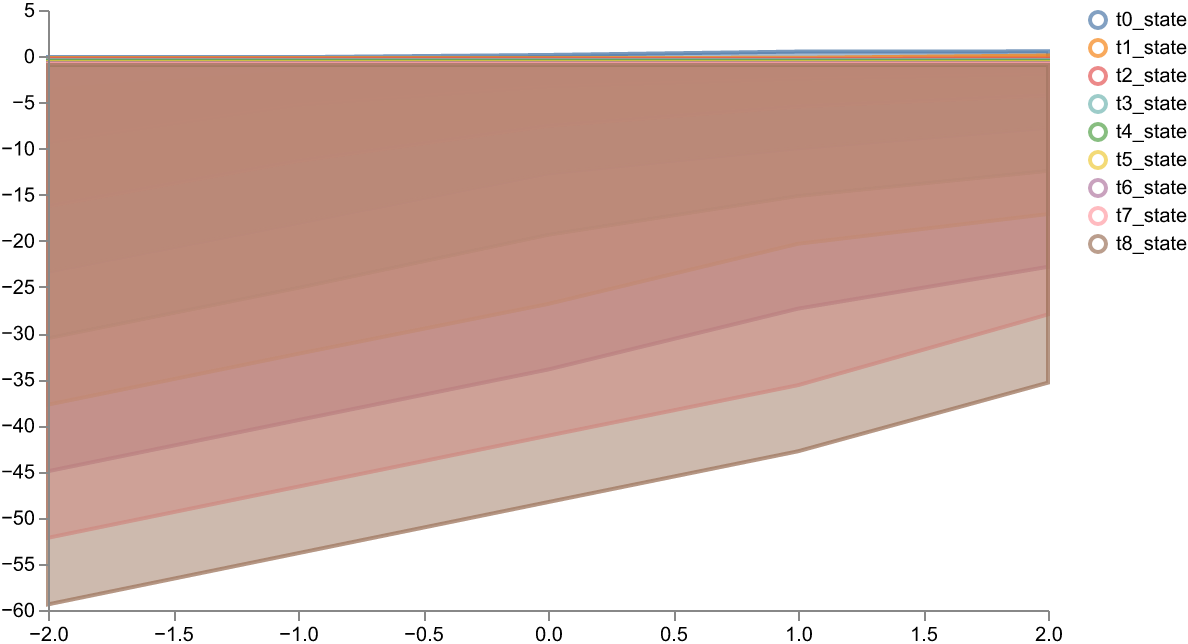

In [40]:
# 1D Advection equation (backward derivative, boundary slope 0.1, 5 discrete points)
model_url = form_model_url(PDE[0], derivative_type[1], dimension[0], boundary_slope[2], num_discrete_points[1])
x_state_dict = extract_model_states_and_mesh(model_url)

result = pyciemss.sample(model_url, end_time, logging_step_size, num_samples, start_time=start_time)
display(result["data"].head())

# Plot results for all states
reconfigured_results = reconfigure_results(result, x_state_dict, num_timepoints)
schema = plots.trajectories(reconfigured_results, keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Sample model and plot the results
1D Advection equation (backward derivative, boundary slope 0.2, 5 discrete points)

Model name: advection_backward_1_0.2_5.json
State names: ['a_0_state', 'a_1_state', 'a_2_state', 'a_3_state', 'a_4_state']
X-coordinates: [-2.0, -1.0, 0.0, 1.0, 2.0]


,timepoint_id,sample_id,persistent_dx_param,persistent_u_param,a_0_state,a_1_state,a_2_state,a_3_state,a_4_state
0,0,0,0.701828,0.791111,-1.616879,-1.459446,-1.301896,-1.143910,-0.984794
1,1,0,0.701828,0.791111,-3.391167,-3.233763,-3.076358,-2.918953,-2.761549
2,2,0,0.701828,0.791111,-5.165453,-5.008049,-4.850644,-4.693240,-4.535835
3,3,0,0.701828,0.791111,-6.939740,-6.782335,-6.624926,-6.467530,-6.310121
4,4,0,0.701828,0.791111,-8.714025,-8.556622,-8.399217,-8.241813,-8.084409


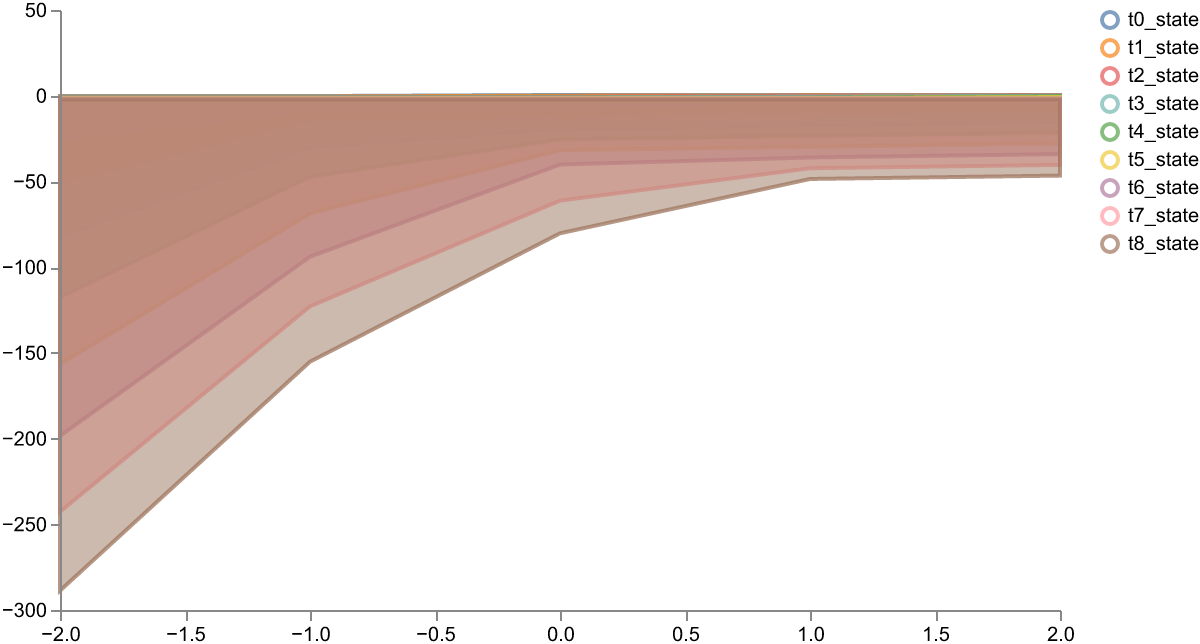

In [42]:
# 1D Advection equation (backward derivative, boundary slope 0.2, 5 discrete points)
model_url = form_model_url(PDE[0], derivative_type[1], dimension[0], boundary_slope[3], num_discrete_points[1])
x_state_dict = extract_model_states_and_mesh(model_url)

result = pyciemss.sample(model_url, end_time, logging_step_size, num_samples, start_time=start_time)
display(result["data"].head())

# Plot results for all states
reconfigured_results = reconfigure_results(result, x_state_dict, num_timepoints)
schema = plots.trajectories(reconfigured_results, keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# 1-D Halfar Equation
$$ \frac{\partial h}{\partial t} = \frac{2}{n + 2} A \left( \rho g \right)^n \frac{\partial}{\partial x} \left( \frac{\partial h}{\partial x} \left| \frac{\partial h}{\partial x} \right|^{n - 1} h^{n + 2} \right) $$ 


### Sample model and plot the results
1D Halfar equation (backward derivative, boundary slope 0.0, 3 discrete points)

In [36]:
# 1D Halfar equation (backward derivative, boundary slope 0.0, 3 discrete points)
model_url = form_model_url(PDE[1], derivative_type[1], dimension[0], boundary_slope[0], num_discrete_points[0])
x_state_dict = extract_model_states_and_mesh(model_url)

result = pyciemss.sample(model_url, end_time, logging_step_size, num_samples, start_time=start_time)
display(result["data"].head())

# Plot results for all states
reconfigured_results = reconfigure_results(result, x_state_dict, num_timepoints)
schema = plots.trajectories(reconfigured_results, keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

Model name: halfar_backward_1_0.0_3.json


JSONDecodeError: Extra data: line 1 column 4 (char 3)